In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
  %cd /content/drive/MyDrive/ML_final_project/ 

/content/drive/.shortcut-targets-by-id/1ZbBnRAb93hNI6T66M2GC0yuTfoZX8DNz/ML_final_project


In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [ ]:
# Root directory for dataset
dataroot = "data/celeba"

# Test data 
test_dataroot = "data/celeba_test"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

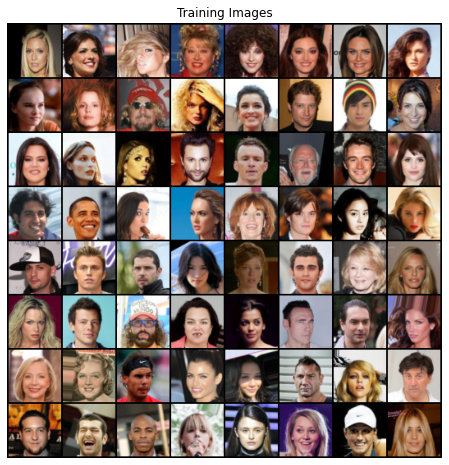

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class ParentAutoEncoder(nn.Module):
  def __init__(self, ngpu):
    super(ParentAutoEncoder, self).__init__()
    self.ngpu = ngpu
    self.encoder = nn.Sequential(
        # input is (nc) x 64 x 64
        nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf) x 32 x 32
        nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 2),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf*2) x 16 x 16
        nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 4),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf*4) x 8 x 8
        nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 8),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf*8) x 4 x 4
        nn.Conv2d(ndf * 8, nz, 4, 1, 0, bias=False),
        nn.BatchNorm2d(nz),
        nn.LeakyReLU(True)
    )
    self.decoder = nn.Sequential(
        # input is Z, going into a convolution
        nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
        nn.BatchNorm2d(ngf * 8),
        nn.ReLU(True),
        # state size. (ngf*8) x 4 x 4
        nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 4),
        nn.ReLU(True),
        # state size. (ngf*4) x 8 x 8
        nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 2),
        nn.ReLU(True),
        # state size. (ngf*2) x 16 x 16
        nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(True),
        # state size. (ngf) x 32 x 32
        nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
        nn.Tanh()
    )
  def forward(self, input):
    latent = self.encoder(input)
    output = self.decoder(latent)
    return latent, output


In [ ]:
# Create the parent autoencoders
netPAE1 = ParentAutoEncoder(ngpu).to(device)
netPAE2 = ParentAutoEncoder(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netPAE1 = nn.DataParallel(netPAE1, list(range(ngpu)))
    netPAE2 = nn.DataParallel(netPAE2, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netPAE1.apply(weights_init)
netPAE2.apply(weights_init)

# Print the model
print(netPAE1)

ParentAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 100, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): BatchNorm2d(100, eps=1e-05, momentum=

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()
criterion_reconstruct = nn.MSELoss()
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.
multiplier = 10

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerP1 = optim.Adam(netPAE1.parameters(), lr=lr*10, betas=(beta1, 0.999))
optimizerP2 = optim.Adam(netPAE2.parameters(), lr=lr*10, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
P1_losses = []
P2_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ############################
        # (2) Create parent latent space
        ###########################
        ind1 = torch.randperm(b_size)
        ind2 = torch.randperm(b_size)
        parent1 = real_cpu[ind1, :, :, :]
        parent2 = real_cpu[ind2, :, :, :]
        latent1, parent1_reconstruct = netPAE1(parent1)
        latent2, parent2_reconstruct = netPAE2(parent2)

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = 0.3 * torch.randn(b_size, nz, 1, 1, device=device) + latent1 + latent2
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (3) Update G network: maximize log(D(G(z))) Update Parent Autoencoders
        ###########################
        netG.zero_grad()
        netPAE1.zero_grad()
        netPAE2.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate parent reconstruction loss
        errP1 = multiplier*criterion_reconstruct(parent1_reconstruct, parent1)
        errP2 = multiplier*criterion_reconstruct(parent2_reconstruct, parent2)
        
        total_errG = errG + errP1 + errP2
        # Calculate gradients for G
        total_errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        optimizerP1.step()
        optimizerP2.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f\tP1: %.4f\tP2: %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2, errP1.item(), errP2.item()))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        P1_losses.append(errP1.item())
        P2_losses.append(errP2.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                latent1, out = netPAE1(parent1[:64, :, :, :])
                latent2, out = netPAE2(parent2[:64, :, :, :])
                fake = netG(fixed_noise+latent1+latent2).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/50][0/63]	Loss_D: 1.3789	Loss_G: 3.2829	D(x): 0.4558	D(G(z)): 0.3134 / 0.0548	P1: 4.0297	P2: 3.9239
[0/50][50/63]	Loss_D: 0.5139	Loss_G: 8.2909	D(x): 0.9316	D(G(z)): 0.2529 / 0.0008	P1: 1.4098	P2: 1.3249
[1/50][0/63]	Loss_D: 1.5004	Loss_G: 3.6222	D(x): 0.3727	D(G(z)): 0.0309 / 0.0616	P1: 1.3691	P2: 1.3713
[1/50][50/63]	Loss_D: 1.7698	Loss_G: 3.9755	D(x): 0.8172	D(G(z)): 0.7594 / 0.0241	P1: 0.9646	P2: 0.9832
[2/50][0/63]	Loss_D: 1.2175	Loss_G: 2.0855	D(x): 0.5301	D(G(z)): 0.3074 / 0.1449	P1: 0.9662	P2: 1.1104
[2/50][50/63]	Loss_D: 2.1051	Loss_G: 5.6634	D(x): 0.8762	D(G(z)): 0.8389 / 0.0050	P1: 1.0063	P2: 0.8894
[3/50][0/63]	Loss_D: 1.5213	Loss_G: 3.1308	D(x): 0.6024	D(G(z)): 0.5615 / 0.0573	P1: 0.9998	P2: 0.9366
[3/50][50/63]	Loss_D: 1.0622	Loss_G: 2.1140	D(x): 0.6124	D(G(z)): 0.3616 / 0.1481	P1: 0.7371	P2: 0.8075
[4/50][0/63]	Loss_D: 1.5318	Loss_G: 1.6474	D(x): 0.3670	D(G(z)): 0.2032 / 0.2465	P1: 0.7966	P2: 0.8844
[4/50][50/63]	Loss_D: 1.2732	Loss_G: 3.2653

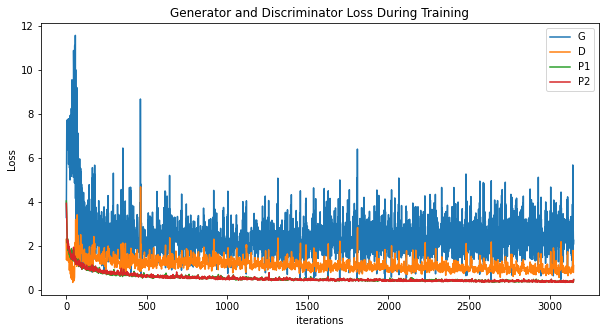

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.plot(P1_losses, label="P1")
plt.plot(P2_losses, label="P2")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

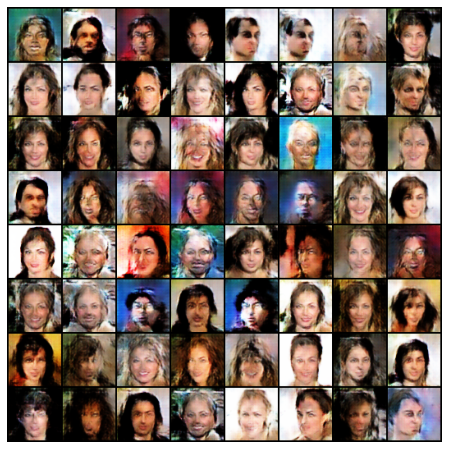

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")        
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

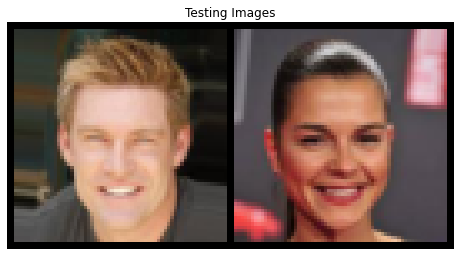

In [ ]:
###################
####  Testing  ####
###################
test_dataset = dset.ImageFolder(root=test_dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=2,
                                         shuffle=True, num_workers=workers)
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Testing Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:2], padding=2, normalize=True, nrow=2).cpu(),(1,2,0)))

In [ ]:
img_list = []
real_batch = next(iter(dataloader))
real_cpu = real_batch[0].to(device)
p1 = real_cpu[0,:,:,:].repeat(64,1 ,1 ,1)
p2 = real_cpu[1,:,:,:].repeat(64, 1,1 , 1)
latent1, parent1_reconstruct = netPAE1(p1)
latent2, parent2_reconstruct = netPAE2(p2)
noise = torch.randn(64, nz, 1, 1, device=device) + latent1 + latent2
with torch.no_grad():
  fake = netG(noise+latent1+latent2).detach().cpu()

img_list.append(vutils.make_grid(parent1_reconstruct.detach().cpu(), padding=2, normalize=True))
img_list.append(vutils.make_grid(parent2_reconstruct.detach().cpu(), padding=2, normalize=True))
img_list.append(vutils.make_grid(fake, padding=2, normalize=True))


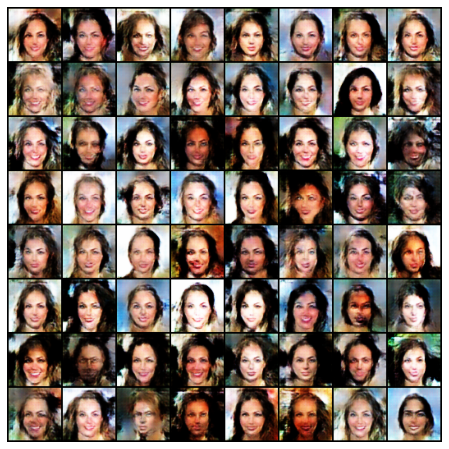

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

# FID

In [ ]:
import torch
from torch import nn, optim

from collections import OrderedDict

from ignite.engine import *
from ignite.handlers import *
from ignite.metrics import *
from ignite.utils import *
from ignite.contrib.metrics.regression import *
from ignite.contrib.metrics import *

# create default evaluator for doctests

def eval_step(engine, batch):
    return batch

default_evaluator = Engine(eval_step)

# create default optimizer for doctests

param_tensor = torch.zeros([1], requires_grad=True)
default_optimizer = torch.optim.SGD([param_tensor], lr=0.1)

# create default trainer for doctests
# as handlers could be attached to the trainer,
# each test must define his own trainer using `.. testsetup:`

def get_default_trainer():

    def train_step(engine, batch):
        return batch

    return Engine(train_step)

# create default model for doctests

default_model = nn.Sequential(OrderedDict([
    ('base', nn.Linear(4, 2)),
    ('fc', nn.Linear(2, 1))
]))

manual_seed(666)

metric = FID(num_features=1, feature_extractor=default_model)
metric.attach(default_evaluator, "fid")
y_true = torch.ones(10, 4)
y_pred = torch.ones(10, 4)
state = default_evaluator.run([[y_pred, y_true]])
print(state.metrics["fid"])

0.0


/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs_sqrtm.py:186: RuntimeWarning: invalid value encountered in double_scalars
  arg2 = norm(X.dot(X) - A, 'fro')**2 / norm(A, 'fro')
